<a href="https://colab.research.google.com/github/Abel-kaiki/Modelling/blob/main/NN_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries used in this project

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.layers import Input
from keras.models import Model

#Colab drive mount
from google.colab import drive
drive.mount("/content/drive")

#Load dataset
path = '/content/drive/MyDrive/ColabNotebooks/Datasets/R_W_Wine_quality.csv'

Mounted at /content/drive


In [ ]:
# Initialise main dataset
data = pd.read_csv(path)

# Select which dataset-subset to use -- Comment out unused subset
# Take % of data set
fraction = 1 #Edit this to desired fraction
data = data.sample(frac=fraction, random_state = 42) #For fraction of dataset testing, comment out if using below equal red/wine subset

# Create dataset with equal amounts of red and white wine entries
data_white = data[data.type == 'White']
data_red = data[data.type == 'Red']
data_equal = data_white.sample(n = len(data_red), random_state = 42)
#data = pd.concat([data_red, data_equal]) #For equal amount red/wine dataset testing, commount out if using above % fraction subset

# See min and max quality of subset
print('min is ', min(data['quality']), 'max is ', max(data['quality']))

min is  3 max is  8


In [ ]:
# Preparing dataframe - Splitting

# Select amount of physicochemical parameters used

#inputs = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'] #11 param
#inputs = ['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'alcohol'] #6 param
inputs = ['density', 'alcohol', 'pH'] #3 Param

# Initialise inputs dataframe
data['Id'] = data.index
X = data[['Id'] + inputs] # include Id for tracking

# Need to convert 'type' to numerical (float OR binary)
data['type_int'] = (data['type'] == 'Red') #Red = True (1), White = False (0)
data['type_int'] = data['type_int'].astype(float)
data['quality'] = data['quality'].astype(float)

# Initialise outputs dataframe
y = data[['quality','type_int']]

# Split data into training and testing sets, retaining IDs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# test_size : testing-training splits. 0.2 = 20% reserved for testing.

In [ ]:
#Preparing df - Scaling
# fit and transform, scale between 1 and 0
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[inputs])
X_test_scaled = scaler.fit_transform(X_test[inputs])

In [ ]:
# Build model

# Sequential model - regression model with linear output function

model = Sequential([
    Dense(8, activation='sigmoid', input_shape=(len(inputs),)), # First hidden layer with n neurons, sigmoidal activation function
    Dense(8, activation='sigmoid'), # second hidden layer with n neurons, sigmoidal activation function.
    #Dense(8, activation='sigmoid'), # third hiddne layer with n neurons, sigmoidal activation function.
    Dense(1) # output layer, linear activation function.
])

# Setup optimiser
opti = Adam(learning_rate= 0.001) # Adam optimiser, default learning rate is 0.001
#opti = SGD() #SGD opti, default learning rate is 0.01

# Compile
model.compile(optimizer = opti, loss='mse') # Change loss function here (mae, msle, mse)

In [ ]:
# Fitting model
model.fit(X_train_scaled, y_train['quality'].values, validation_split=0.2, batch_size = 30, epochs = 400) # Change batch size and epochs here

Epoch 1/400
69/69 [==============================] - 2s 24ms/step - loss: 23.7793 - val_loss: 20.0330
Epoch 2/400
69/69 [==============================] - 0s 4ms/step - loss: 17.4382 - val_loss: 14.3437
Epoch 3/400
69/69 [==============================] - 0s 5ms/step - loss: 12.3413 - val_loss: 9.9567
Epoch 4/400
69/69 [==============================] - 0s 4ms/step - loss: 8.5428 - val_loss: 6.8175
Epoch 5/400
69/69 [==============================] - 0s 5ms/step - loss: 5.8591 - val_loss: 4.6392
Epoch 6/400
69/69 [==============================] - 0s 4ms/step - loss: 4.0132 - val_loss: 3.1575
Epoch 7/400
69/69 [==============================] - 0s 4ms/step - loss: 2.7617 - val_loss: 2.1636
Epoch 8/400
69/69 [==============================] - 0s 4ms/step - loss: 1.9302 - val_loss: 1.5277
Epoch 9/400
69/69 [==============================] - 0s 4ms/step - loss: 1.4087 - val_loss: 1.1404
Epoch 10/400
69/69 [==============================] - 0s 5ms/step - loss: 1.0967 - val_loss: 0.9222
Epo

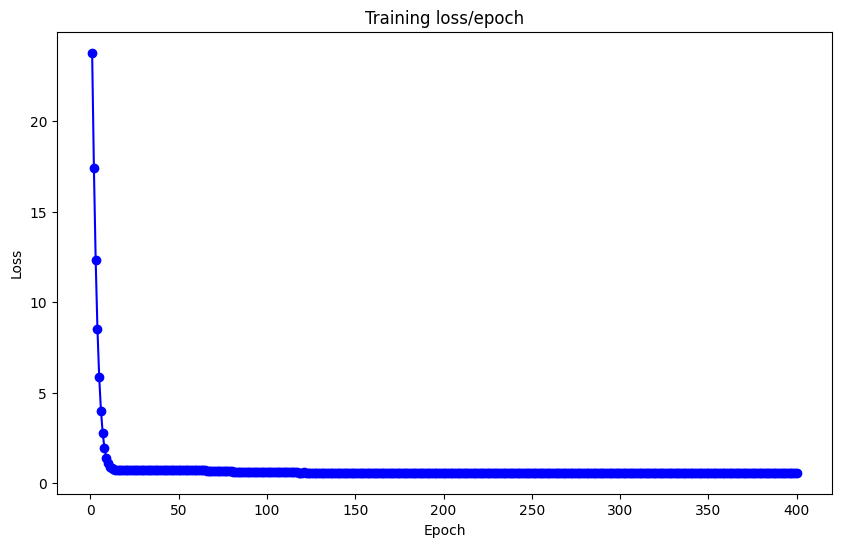

In [ ]:
# Extract losses for training datasets
training_loss = model.history.history['loss']
epochs = range(1, len(training_loss) + 1)

# Plot training loss
plt.figure(figsize=(10,6))
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.title('Training loss/epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluate model - Quality

# Use trained model to make predictions based on scaled test data
predictions = model.predict(X_test_scaled)
predictions_rounded = predictions.round(0)

# Quick min/max check
print('max is:', max(predictions_rounded), 'min is:', min(predictions_rounded))

20/20 [==============================] - 0s 2ms/step
max is: [7.] min is: [5.]


In [ ]:
# Actual quality for test data
preds = predictions_rounded.flatten()
actual_quality = y_test['quality'].values

#Calculate accuracy
correct_predictions = (preds == actual_quality).sum()
accuracy = correct_predictions / len(actual_quality)
print(accuracy*100)

# % of erroneous predicted qualities that are within 1 quality score of the true quality
pred_range = preds - actual_quality
in_range = 100*((pred_range == 1).sum() + (pred_range == -1).sum())/(len(pred_range) - (pred_range == 0).sum())
print(in_range, '% of erroneous predicted qualities are +-1 of actual quality')

# Ratio between correct predictions, and incorrect predictions that are off by +- 1.
in_range2 = (pred_range == 0).sum()/((pred_range == -1).sum() + (pred_range == 1).sum())
print(in_range2, ': ratio between correct/incorrect by +-1') # If returns 1, then there are equal amounts of correct predictions as there are predictions off by 1.

# Print converged training loss value
print(min(training_loss))

50.31250000000001
91.82389937106919 % of erroneous predicted qualities are +-1 of actual quality
1.1027397260273972 : ratio between correct/incorrect by +-1
0.5856682658195496


In [72]:
# DOE analysis

# Import DOE data
path_doe = '/content/drive/MyDrive/ColabNotebooks/Datasets/project2doe.csv'

# Initialise DOE dataset
data_doe = pd.read_csv(path_doe) # We only want DOE entries for quality tests
data_doe = data_doe.loc[9:17]

# Import required packages
from doepy import build #!pip install doepy
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

# Generate full factorial design (3 levels, 2 factors)
doe = build.full_fact(
{'Layers':[1, 2, 3],
'Nodes':[4, 8, 12]}
)

# Get result column (accuracy) and create full DOE matrix
doe_accuracy = data_doe['accuracy']
doe['accuracy'] = doe_accuracy.values

# Linear regression
lm = ols('accuracy ~ C(Layers) + C(Nodes)+ C(Nodes*Layers)', doe).fit()
print(lm.summary())

with open('ols_summary.csv', 'w') as fh:
    fh.write(lm.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9965
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.650
Time:                        12:01:12   Log-Likelihood:                -10.712
No. Observations:                   9   AIC:                             37.42
Df Residuals:                       1   BIC:                             39.00
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             